In [ ]:
from pathlib import Path
import os

DAY = "20251201"
Version = "v1"

PROJECT_ROOT = Path(os.getenv("LLMSC_ROOT", ".")).resolve()

DATA_DIR = Path(os.getenv("LLMSC_DATA_DIR", PROJECT_ROOT / "input")).resolve()
OUT_DIR  = Path(os.getenv("LLMSC_OUT_DIR",  PROJECT_ROOT / "runs" / f"{DAY}.{Version}")).resolve()
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
RANDOM_SEED = 42
import random, os
import numpy as np
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"🔒 Random seed set to {RANDOM_SEED} for reproducibility.")

🔒 Random seed set to 42 for reproducibility.


In [ ]:
import google.generativeai as genai
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from scipy import io
import adjustText
import gc
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.metrics import confusion_matrix


import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s:%(name)s:%(message)s"
)

from llm_sc_curator import LLMscCurator
from llm_sc_curator.masking import FeatureDistiller

import warnings
warnings.filterwarnings("ignore")

In [ ]:
file_path = DATA_DIR / "tabula-muris-senis-droplet-processed-official-annotations.h5ad"
adata = sc.read_h5ad(file_path)

In [ ]:
adata.obs

,age,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_genes,sex,subtissue,tissue,tissue_free_annotation,n_counts,louvain,leiden
index,,,,,,,,,,,,,,,
AAACCTGCAGGGTACA-1-0-0-0,24m,MACA_24m_M_TONGUE_60_AAACCTGCAGGGTACA,keratinocyte,NA,filiform,droplet,24-M-60,2107.0,male,nan,Tongue,Tongue,5482.0,5,8
AAACCTGCAGTAAGCG-1-0-0-0,24m,MACA_24m_M_TONGUE_60_AAACCTGCAGTAAGCG,keratinocyte,NA,suprabasal,droplet,24-M-60,3481.0,male,nan,Tongue,Tongue,21855.0,19,15
AAACCTGTCATTATCC-1-0-0-0,24m,MACA_24m_M_TONGUE_60_AAACCTGTCATTATCC,keratinocyte,NA,suprabasal,droplet,24-M-60,2599.0,male,nan,Tongue,Tongue,10943.0,19,15
AAACGGGGTACAGTGG-1-0-0-0,24m,MACA_24m_M_TONGUE_60_AAACGGGGTACAGTGG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,3468.0,male,nan,Tongue,Tongue,20665.0,12,11
AAACGGGGTCTTCTCG-1-0-0-0,24m,MACA_24m_M_TONGUE_60_AAACGGGGTCTTCTCG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,3189.0,male,nan,Tongue,Tongue,12925.0,5,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10X_P8_15_TTTGTCAGTACATGTC-1,3m,10X_P8_15_TTTGTCAGTACATGTC,basal epithelial cell of tracheobronchial tree,CL:0000066,nan,droplet,3-M-7/8,NaN,male,nan,Trachea,Trachea,5000.0,51,59
10X_P8_15_TTTGTCAGTGCGCTTG-1,3m,10X_P8_15_TTTGTCAGTGCGCTTG,mesenchymal progenitor cell,CL:0008019,nan,droplet,3-M-7/8,NaN,male,nan,Trachea,Trachea,5984.0,11,33
10X_P8_15_TTTGTCAGTTGTCGCG-1,3m,10X_P8_15_TTTGTCAGTTGTCGCG,endothelial cell,CL:0000115,nan,droplet,3-M-7/8,NaN,male,nan,Trachea,Trachea,6507.0,40,32


In [ ]:
set(adata.obs["cell_ontology_class"])

{'B cell',
 'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta T cell',
 'DN3 thymocyte',
 'DN4 thymocyte',
 'Kupffer cell',
 'Langerhans cell',
 'NK cell',
 'Schwann cell',
 'T cell',
 'adventitial cell',
 'alveolar macrophage',
 'basal cell',
 'basal cell of epidermis',
 'basal epithelial cell of tracheobronchial tree',
 'basophil',
 'bladder cell',
 'bladder urothelial cell',
 'blood cell',
 'bronchial smooth muscle cell',
 'brush cell',
 'cardiac neuron',
 'cardiomyocyte',
 'chondrocyte',
 'ciliated columnar cell of tracheobronchial tree',
 'classical monocyte',
 'club cell of bronchiole',
 'dendritic cell',
 'double negative T cell',
 'duct epithelial cell',
 'endocardial cell',
 'endothelial cell',
 'endothelial cell of coronary artery',
 'endothelial cell of hepatic sinusoid',
 'endothelial cell of lymphatic vessel',
 'enterocyte of epithelium of large intestine',
 'epidermal cell',
 'epithelial cell',
 'epithelial cell of large intestine',
 'epithelial cell of proxim

In [ ]:
mask_b = (
    adata.obs["cell_ontology_class"].str.contains(r"\bB cell\b", regex=True, na=False)
    & ~adata.obs["cell_ontology_class"].str.contains(r"pancreatic B cell", na=False)
)
adata_b = adata[mask_b].copy()
set(adata_b.obs["cell_ontology_class"])

{'B cell',
 'immature B cell',
 'late pro-B cell',
 'naive B cell',
 'precursor B cell'}

In [ ]:
print(f"\n Loading data...: {save_path}")
adata_sub = sc.read_h5ad(save_path)
print("\nCell counts per cluster (Should be balanced approx ~300 if 3 datasets merged):")
print(adata_sub.obs['meta.cluster'].value_counts().head(10))


 Loading data...: /runs/20251201.v1/mouse_b_benchmark_data.h5ad

Cell counts per cluster (Should be balanced approx ~300 if 3 datasets merged):
meta.cluster
B cell              300
immature B cell     300
late pro-B cell     300
naive B cell        300
precursor B cell    300
Name: count, dtype: int64


📊 Generating diagnostic dotplot for lineage markers...
categories: B cell, immature B cell, late pro-B cell, etc.
var_group_labels: Erythrocyte (Contam), Mast Cell (Contam), pDC/Myeloid (Contam), etc.


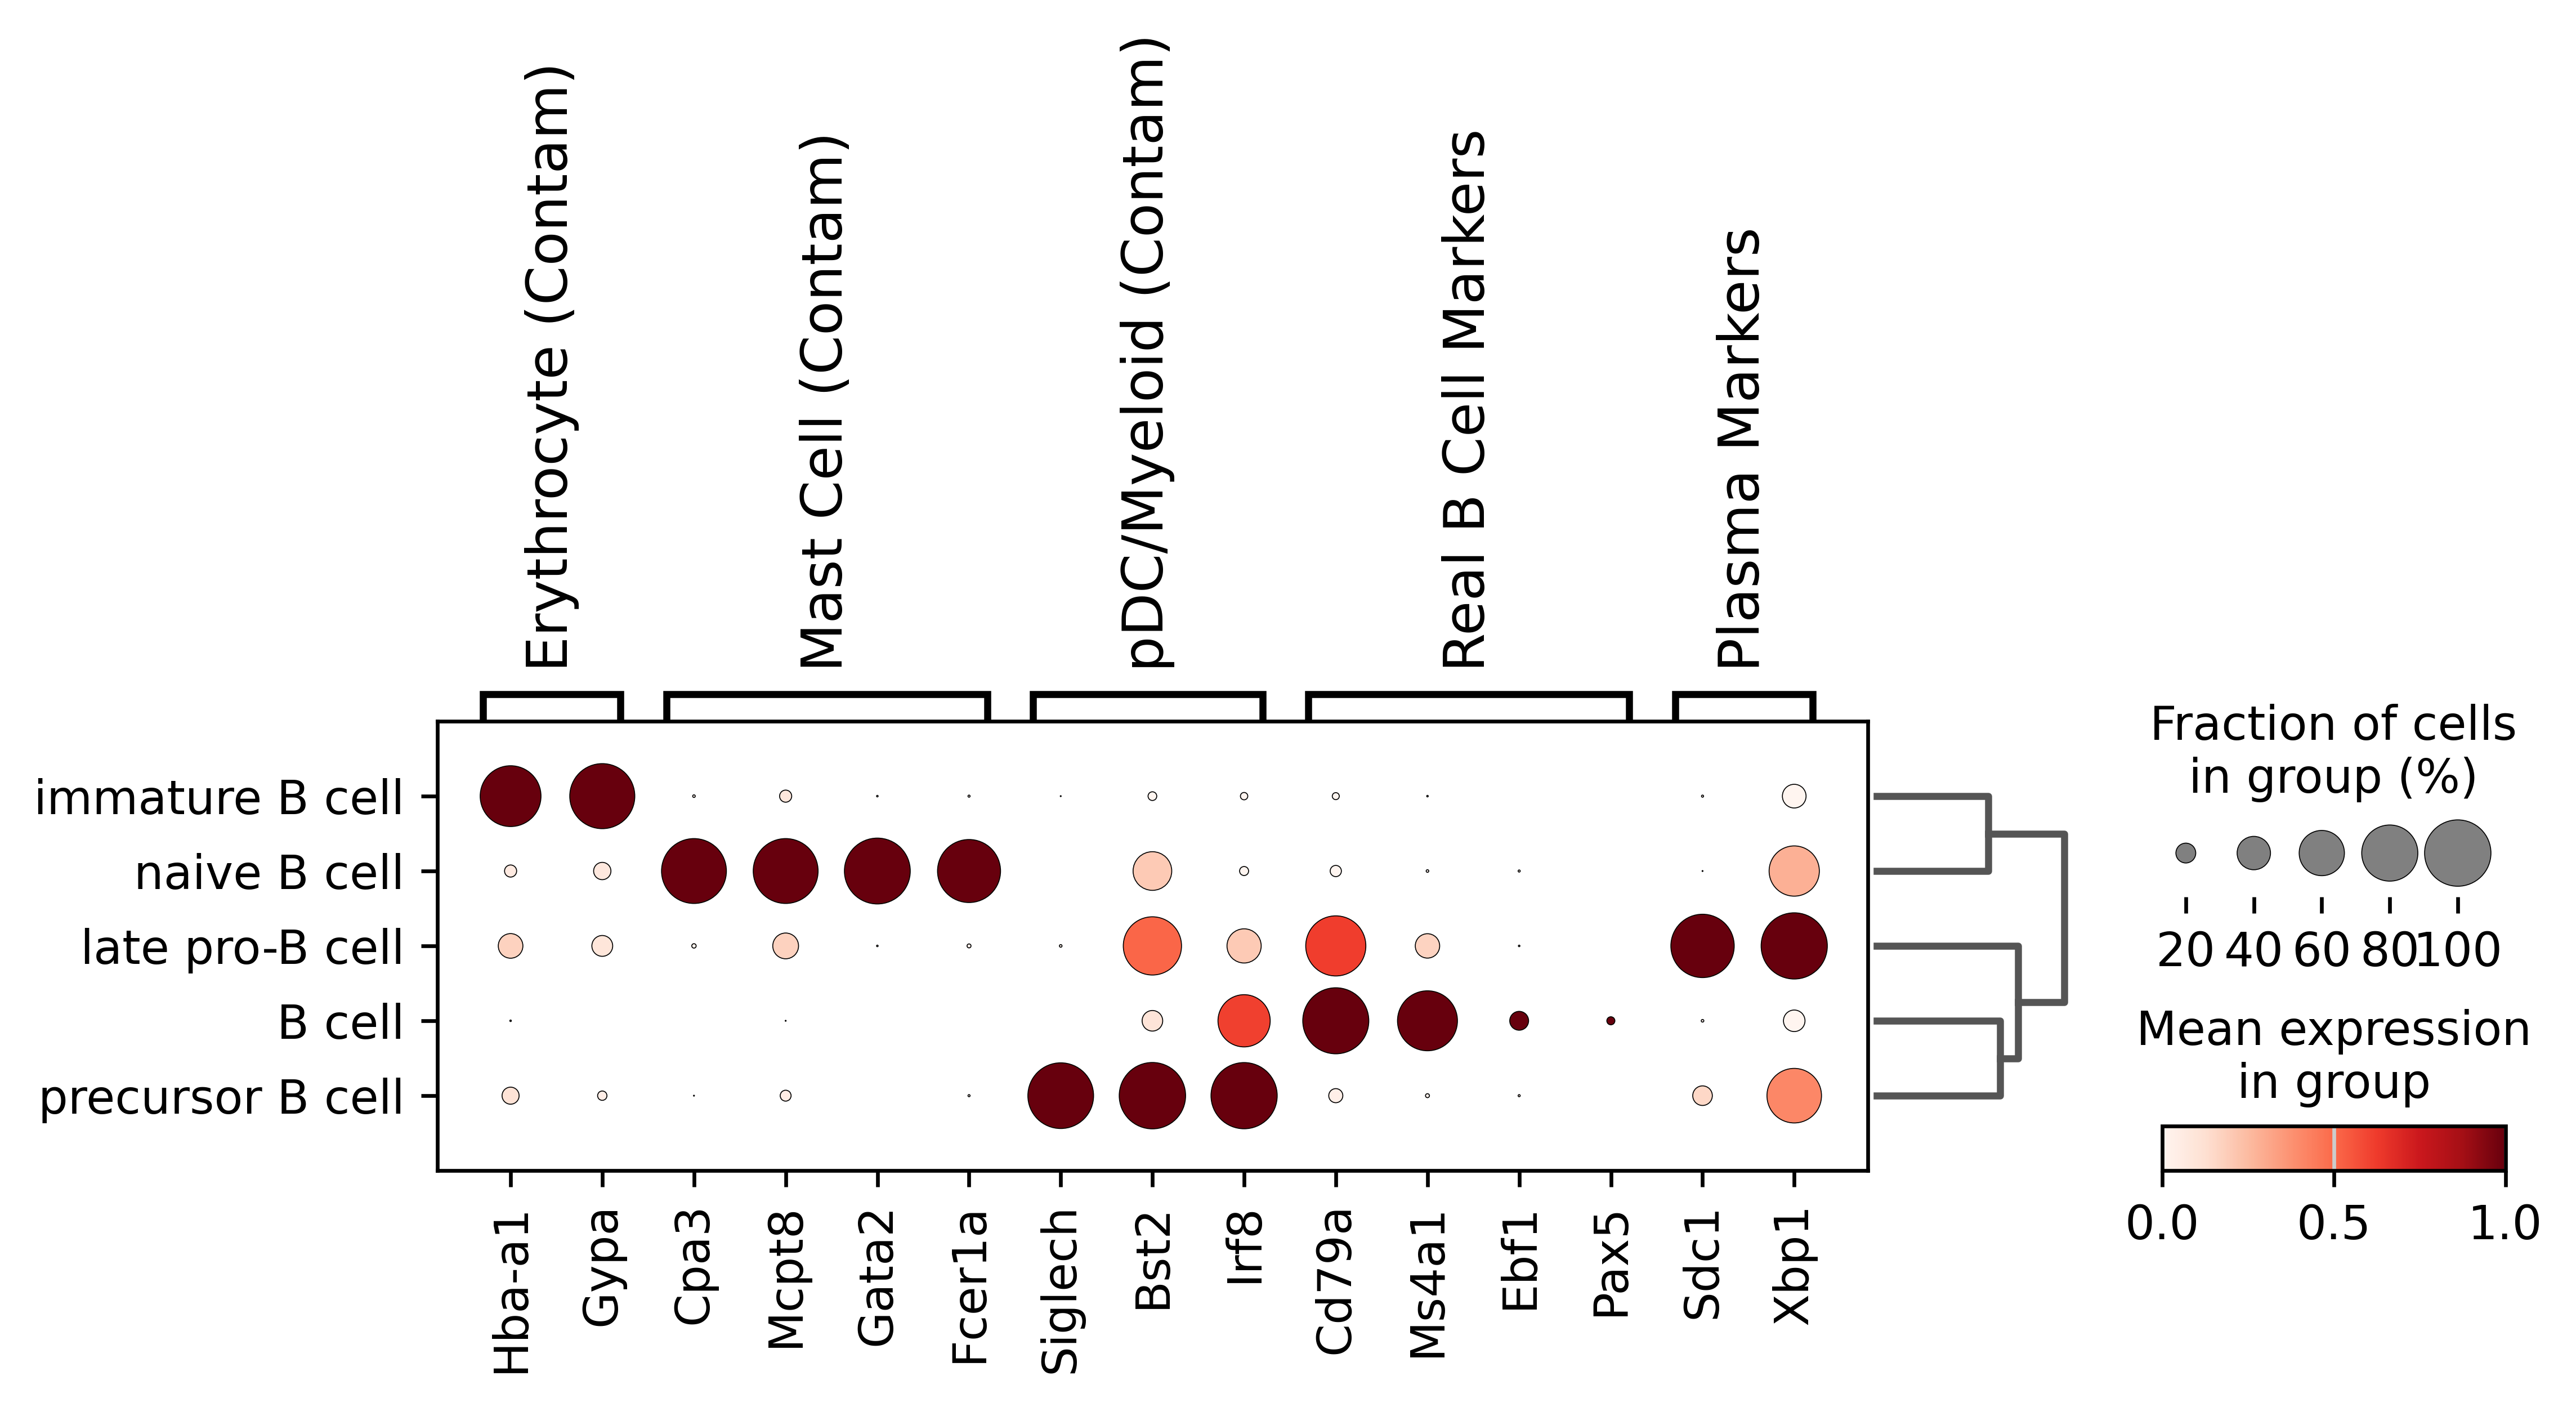

In [ ]:
# ==========================================
# 1. Lineage Identification Marker Set
# ==========================================
check_genes = {
    "Erythrocyte (Contam)": ["Hbb-bs", "Hbb-bt", "Hba-a1", "Gypa"],
    "Mast Cell (Contam)":   ["Cpa3", "Mcpt8", "Gata2", "Fcer1a"],
    "pDC/Myeloid (Contam)": ["Siglech", "Bst2", "Irf8"],
    "Real B Cell Markers":  ["Cd79a", "Ms4a1", "Ebf1", "Pax5"],
    "Plasma Markers":  ["Jchain", "Mzb1", "Sdc1", "Xbp1", "Igkc", "Igha"],
}

available_genes = {
    cat: [g for g in genes if g in adata_sub.var_names]
    for cat, genes in check_genes.items()
}

print("📊 Generating diagnostic dotplot for lineage markers...")
sc.pl.dotplot(
    adata_sub,
    available_genes,
    groupby="meta.cluster",
    standard_scale="var",
    dendrogram=True,
    show=False,
)
plt.savefig(f"{OUT_DIR}/mouse_b_GT_Check.dod.pdf", bbox_inches="tight")
plt.show()
plt.close()


In [ ]:
# ==========================================
# Correct Label Generation Function
# ==========================================

def get_bcell_ground_truth(cluster_name: str) -> str:
    """
    Map Tabula Muris Senis B-lineage meta.cluster to consensus GT categories.

    - immature B cell  : Erythrocyte-like contamination
    - naive B cell     : Mast cell-like contamination
    - precursor B cell : pDC / myeloid-like contamination
    - B cell           : bona fide mature B cell
    - late pro-B cell  : mixed / ambiguous (Real B + pDC + Plasma) → B_Other
    """

    s = str(cluster_name).lower().strip()

    if "immature b cell" in s:
        return "Erythrocyte_like"   # original: immature B cell

    if "naive b cell" in s:
        return "Mast_like"      # original: naive B cell

    if "precursor b cell" in s:
        return "pDC_Myeloid_like"    # original: precursor B cell

    if s.startswith("b cell"):
        return "Mature_B"

    if "late pro-b cell" in s:
        return "B_Other"            # mixed / ambiguous → 評価から除外

    return "B_Other"


print("Applying B-cell consensus Ground Truth mapping...")
adata_sub.obs["GT_Category"] = adata_sub.obs["meta.cluster"].apply(get_bcell_ground_truth)

print("\n--- Value counts for GT_Category ---")
print(adata_sub.obs["GT_Category"].value_counts())


Applying B-cell consensus Ground Truth mapping...

--- Value counts for GT_Category ---
GT_Category
Mature_B            300
Erythrocyte_like    300
B_Other             300
Mast_like           300
pDC_Myeloid_like    300
Name: count, dtype: int64


🗺  UMAP with original clusters vs consensus GT...


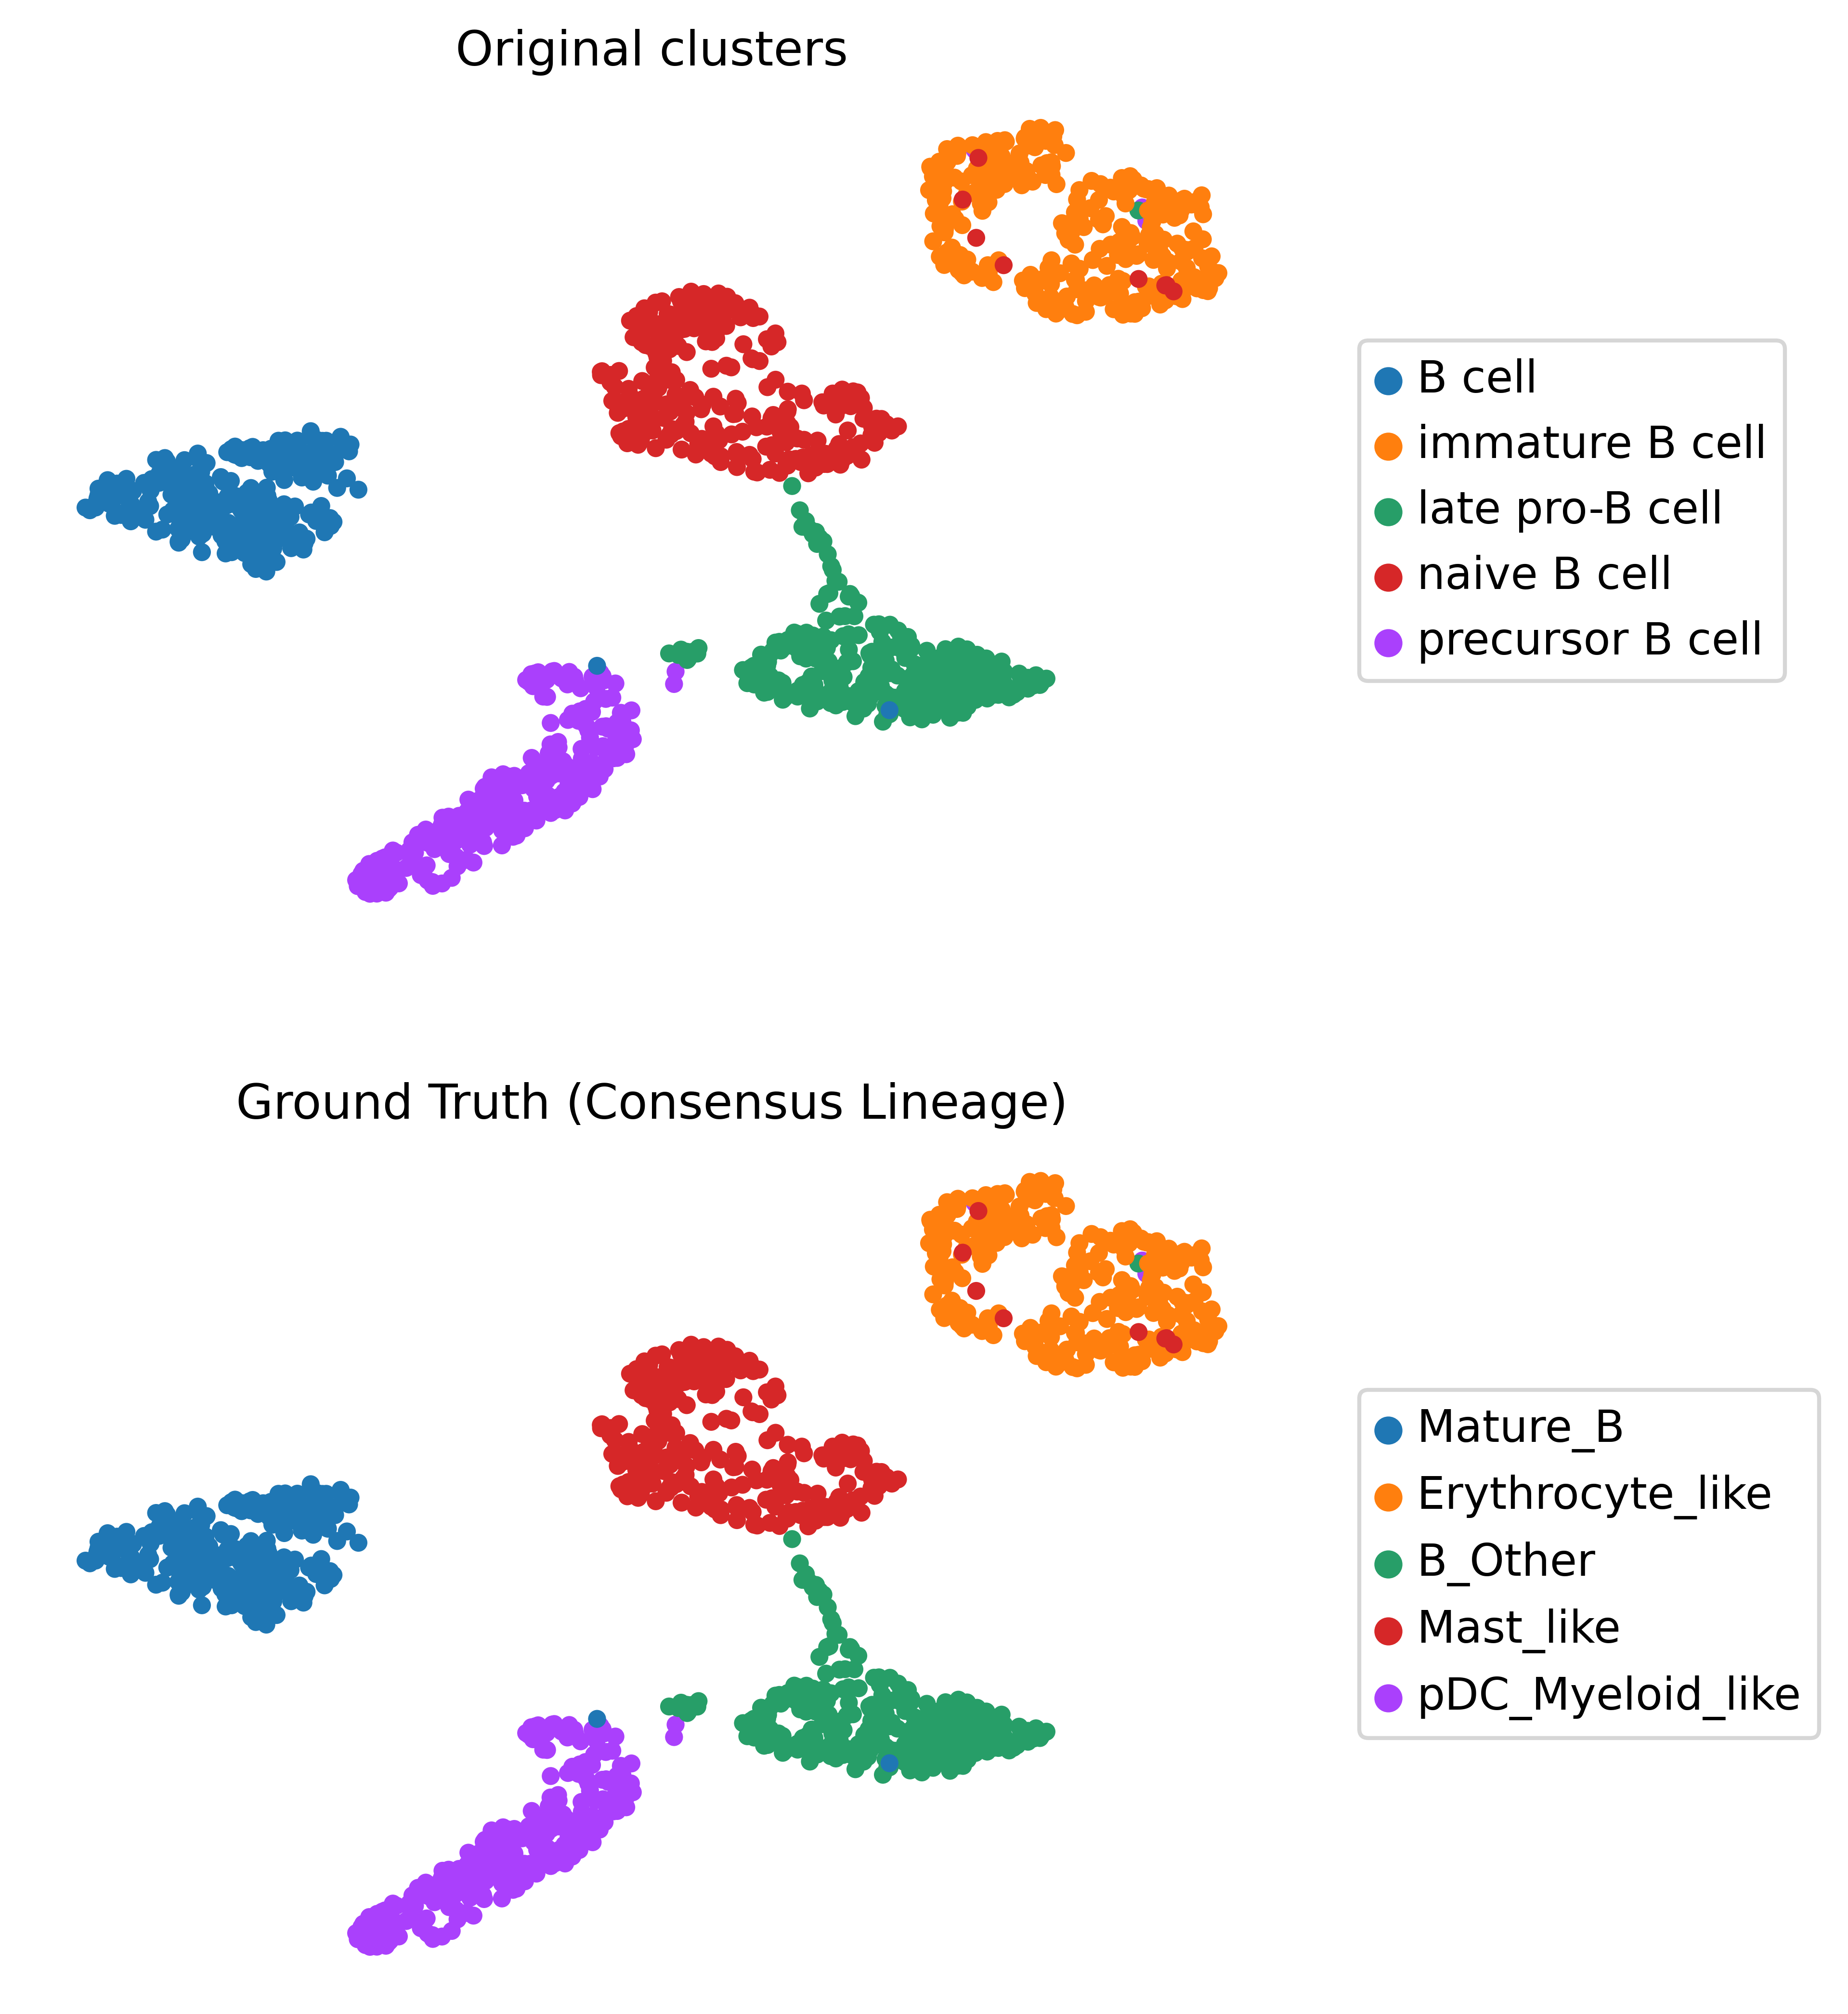

In [ ]:
print("🗺  UMAP with original clusters vs consensus GT...")
sc.pp.neighbors(adata_sub, random_state=42)
sc.tl.umap(adata_sub, random_state=42)

fig = sc.pl.umap(
    adata_sub,
    color=["meta.cluster", "GT_Category"],
    legend_fontsize=10,
    ncols=1,
    title=["Original clusters", "Ground Truth (Consensus Lineage)"],
    frameon=False,
    return_fig=True,
)

for ax in fig.axes:
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(
            handles,
            labels,
            loc="center left",
            bbox_to_anchor=(1.05, 0.5),
            ncol=1,
        )

fig.set_size_inches(6, 8)
fig.tight_layout(rect=[0, 0, 0.85, 1])
fig.savefig(f"{OUT_DIR}/EDFig1e_mouse_b_GT_Check.pdf", bbox_inches="tight")
plt.show()
plt.close()


📊 Dotplot by GT_Category (Mouse B)...
categories: Mature_B, Erythrocyte_like, B_Other, etc.
var_group_labels: Erythrocyte_like, Mast_like, pDC_Myeloid_like, etc.


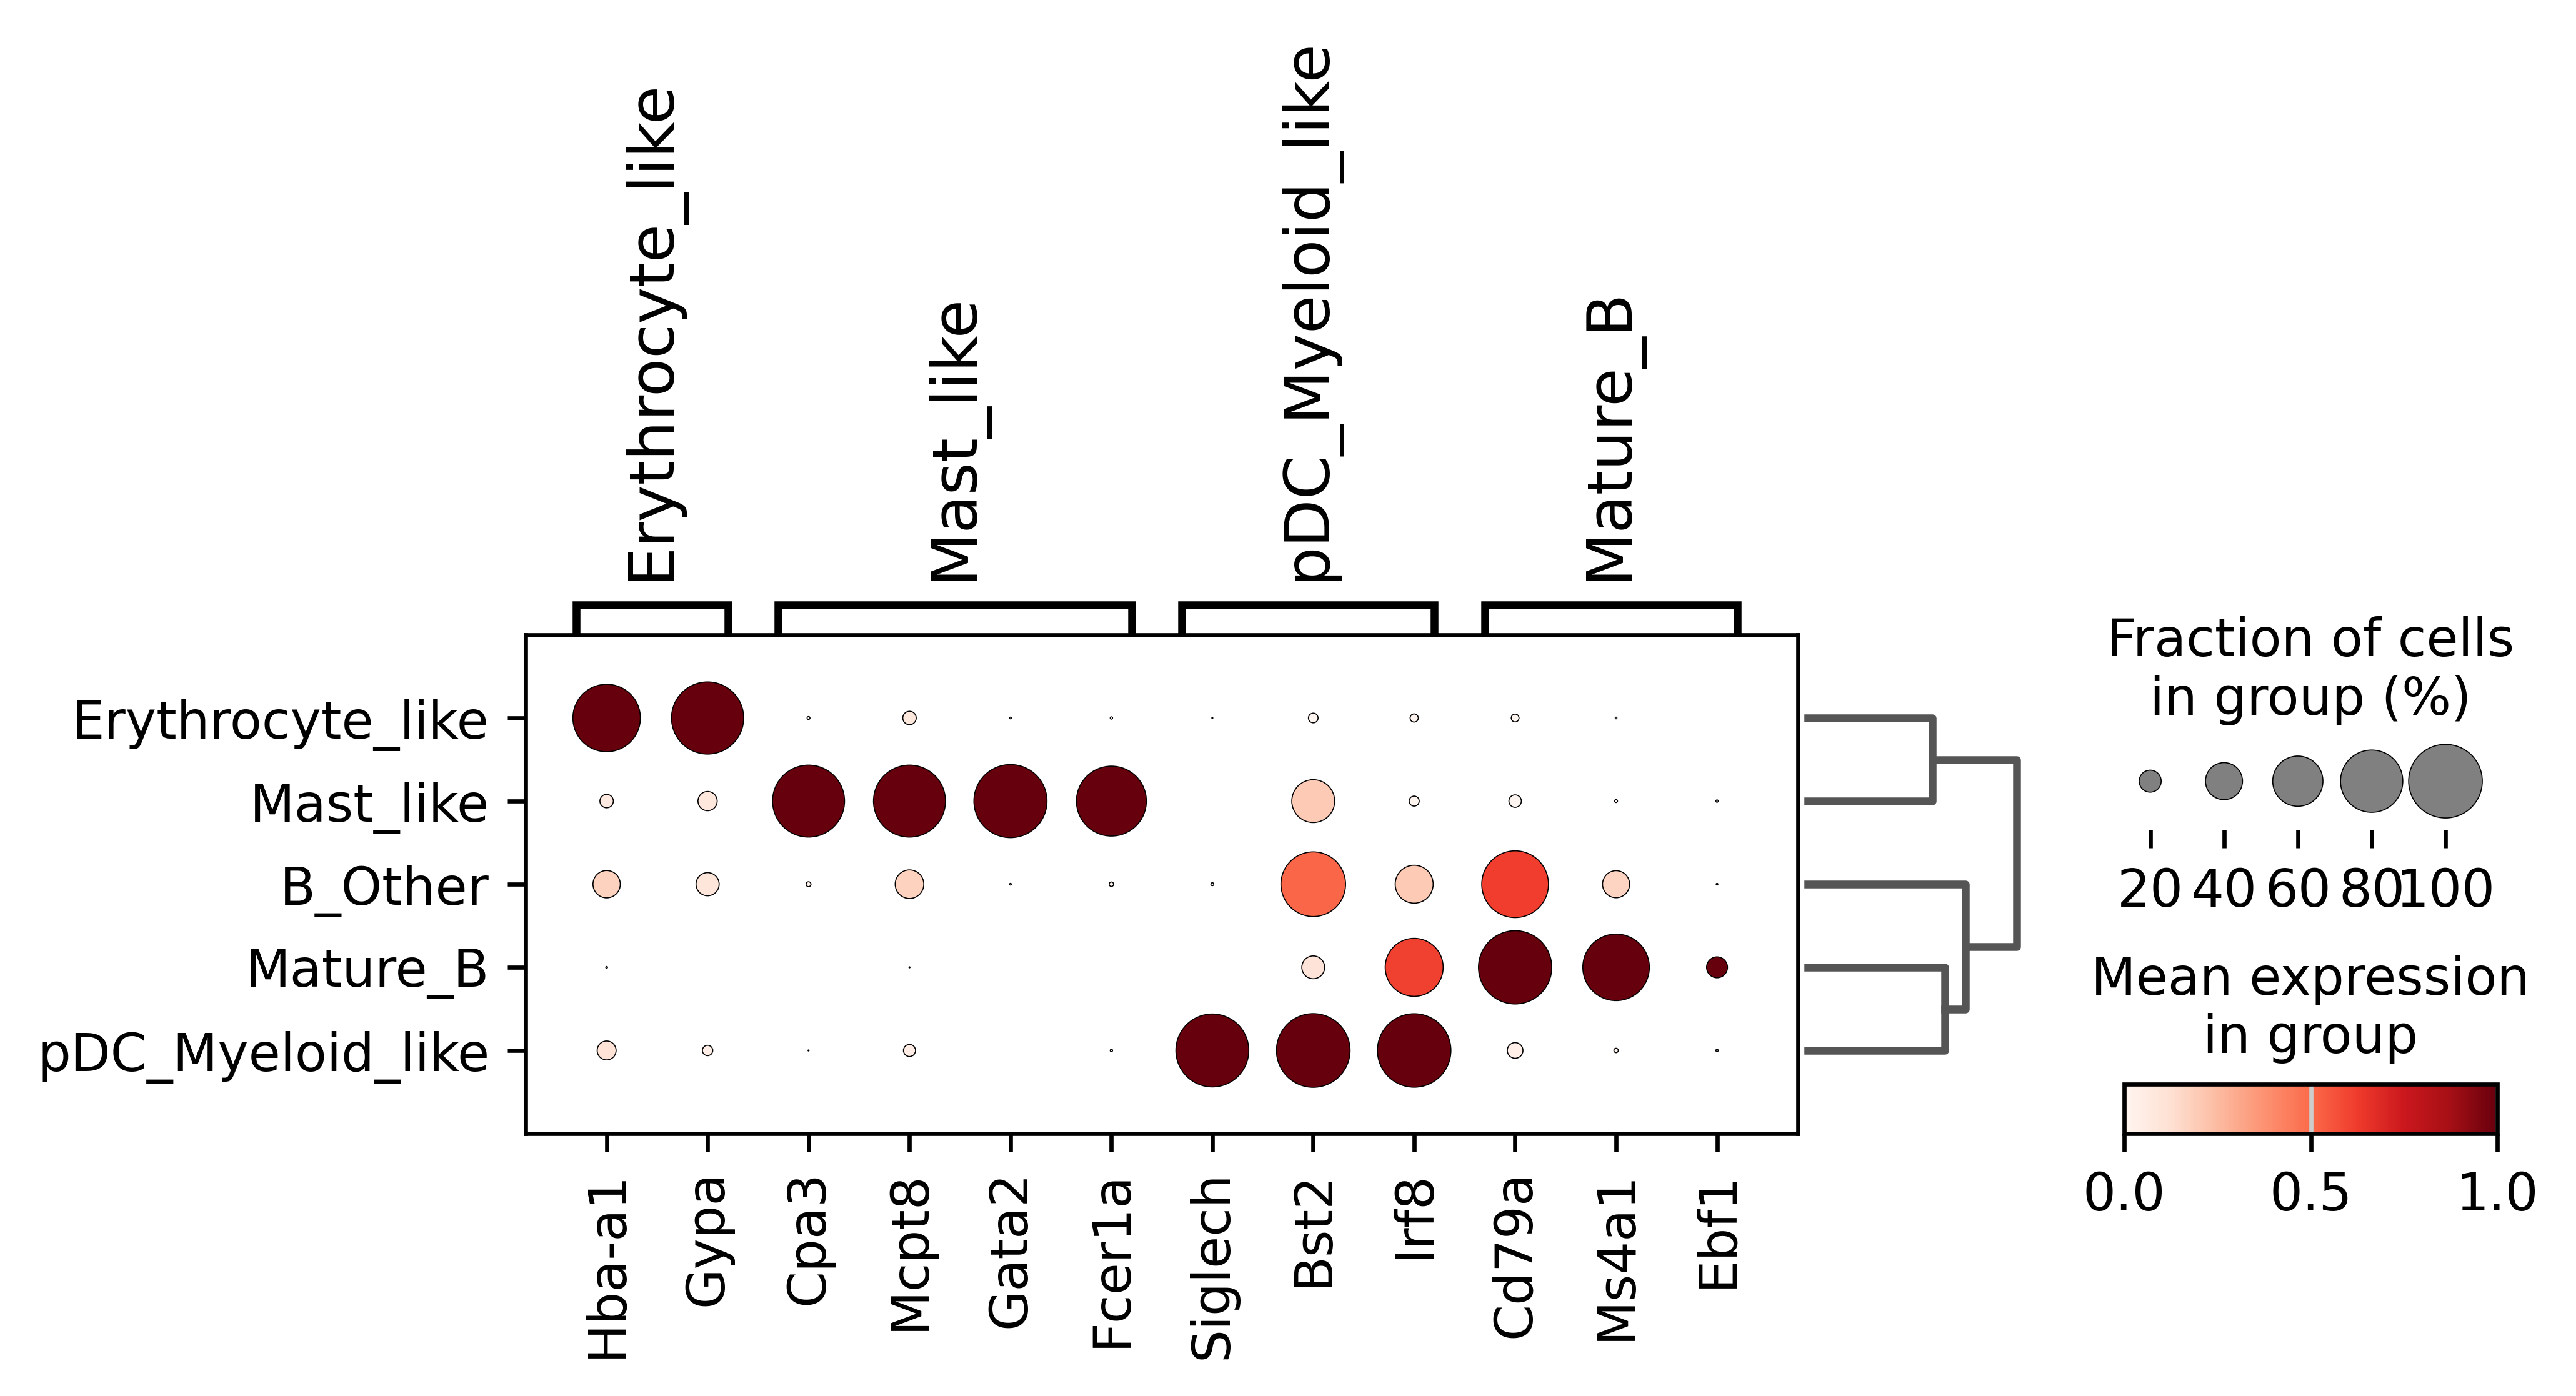

In [ ]:
GT_KEYWORDS_MOUSE_B = {
    "Erythrocyte_like": ["Hbb-bs", "Hbb-bt", "Hba-a1", "Gypa"],
    "Mast_like":    ["Cpa3", "Mcpt8", "Gata2", "Fcer1a"],
    "pDC_Myeloid_like":  ["Siglech", "Bst2", "Irf8"],
    "Mature_B":         ["Cd79a", "Ms4a1", "Ebf1"],
    "Precursor_B":      [],
    "B_Other":          [],
}
var_names = adata_sub.var_names
markers_b = {
    k: [g for g in genes if g in var_names]
    for k, genes in GT_KEYWORDS_MOUSE_B.items()
}
markers_b = {k: v for k, v in markers_b.items() if len(v) > 0}

print("📊 Dotplot by GT_Category (Mouse B)...")
sc.tl.dendrogram(adata_sub, groupby="GT_Category")

fig = sc.pl.dotplot(
    adata_sub,
    markers_b,
    groupby="GT_Category",
    dendrogram=True,
    standard_scale="var",
    return_fig=True,
)
fig.savefig(f"{OUT_DIR}/EDFig1i_mouse_b.pdf", bbox_inches="tight")
plt.show()
plt.close()
